In [1]:
# # Legend and Pattern Extraction from Historical Maps

# Using **Gemini 2.0 Flash-Lite** with structured output to extract:
# 1. **Legend information** - symbols, colors, and their meanings
# 2. **Pattern information** - hatching patterns, fill patterns used in maps

# This notebook processes all cropped maps from the `output/` directory.

In [2]:
# Install required packages if needed
# !pip install google-generativeai pillow

## Setup and Imports

In [3]:
import os
import json
from pathlib import Path
from typing import Optional
from dataclasses import dataclass
from PIL import Image
import matplotlib.pyplot as plt

import google.generativeai as genai
from google.generativeai.types import GenerationConfig

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

## Configure Gemini API

In [ ]:
# Configure Gemini API
api_key = os.getenv("GOOGLE_API_KEY")
if not api_key:
    raise ValueError("Please set GOOGLE_API_KEY environment variable")

genai.configure(api_key=api_key)

# Use Gemini 2.0 Flash-Lite
model = genai.GenerativeModel("gemini-2.5-flash")
print("Gemini 2.5 Flash-Lite configured successfully!")

Gemini 2.5 Flash-Lite configured successfully!


## Define Structured Output Schema for Legend Extraction

In [5]:
# Define the schema for structured output using Gemini's response_schema
# This ensures consistent JSON output from the model

legend_schema = {
    "type": "object",
    "properties": {
        "has_legend": {
            "type": "boolean",
            "description": "Whether the map contains a visible legend"
        },
        "legend_location": {
            "type": "string",
            "description": "Location of the legend on the map (e.g., 'bottom-left', 'top-right', 'none')"
        },
        "legend_items": {
            "type": "array",
            "items": {
                "type": "object",
                "properties": {
                    "symbol_type": {
                        "type": "string",
                        "description": "Type of symbol (e.g., 'solid_fill', 'pattern', 'line', 'icon', 'text_label')"
                    },
                    "visual_description": {
                        "type": "string",
                        "description": "Visual description of the symbol (color, pattern type, line style)"
                    },
                    "meaning": {
                        "type": "string",
                        "description": "What this symbol represents according to the legend"
                    },
                    "pattern_details": {
                        "type": "object",
                        "properties": {
                            "pattern_type": {
                                "type": "string",
                                "description": "Type of pattern (e.g., 'horizontal_lines', 'vertical_lines', 'diagonal_lines', 'crosshatch', 'dots', 'solid', 'none')"
                            },
                            "density": {
                                "type": "string",
                                "description": "Density of the pattern (e.g., 'sparse', 'medium', 'dense')"
                            },
                            "color": {
                                "type": "string",
                                "description": "Color of the pattern or fill"
                            }
                        },
                        "required": ["pattern_type"]
                    }
                },
                "required": ["symbol_type", "visual_description", "meaning"]
            },
            "description": "List of legend items with their symbols and meanings"
        },
        "map_title": {
            "type": "string",
            "description": "Title of the map if visible"
        },
        "map_subject": {
            "type": "string",
            "description": "What the map depicts (e.g., 'election results', 'weather', 'geographic region')"
        },
        "patterns_on_map": {
            "type": "array",
            "items": {
                "type": "object",
                "properties": {
                    "pattern_type": {
                        "type": "string",
                        "description": "Type of pattern observed on the map"
                    },
                    "description": {
                        "type": "string",
                        "description": "Description of where/how this pattern is used"
                    },
                    "likely_meaning": {
                        "type": "string",
                        "description": "Inferred meaning of this pattern based on context"
                    }
                },
                "required": ["pattern_type", "description"]
            },
            "description": "Patterns visible on the map itself (not just in legend)"
        },
        "additional_notes": {
            "type": "string",
            "description": "Any other relevant observations about the map's legend or symbology"
        }
    },
    "required": ["has_legend", "legend_items", "map_subject", "patterns_on_map"]
}

print("Legend extraction schema defined!")

Legend extraction schema defined!


## Legend Extraction Function

In [6]:
def extract_legend_from_map(image_path: Path, model: genai.GenerativeModel) -> dict:
    """
    Extract legend and pattern information from a map image using Gemini.
    
    Args:
        image_path: Path to the map image
        model: Configured Gemini model
        
    Returns:
        Dictionary containing extracted legend and pattern information
    """
    # Load the image
    image = Image.open(image_path)
    
    # Create the prompt for legend extraction
    prompt = """Analyze this historical map image and extract all legend and pattern information.

Please identify:
1. **Legend**: Look for any legend, key, or explanatory text that describes what symbols/patterns mean
2. **Patterns**: Identify all visual patterns used on the map (hatching, cross-hatching, dots, solid fills, etc.)
3. **Symbols**: Any icons, lines, or other symbols with specific meanings
4. **Map Context**: What the map is about and what it's showing

For each pattern or symbol, describe:
- The visual appearance (color, pattern type, line style)
- What it represents according to the legend (if present)
- If no legend is present, make your best inference about what patterns might represent

Pay special attention to:
- Shading patterns (diagonal lines, horizontal lines, vertical lines, crosshatch)
- Fill patterns (solid, dotted, striped)
- Color distinctions (even in black and white maps, note grayscale variations)
- Any text labels that explain symbology"""

    # Configure generation with structured output
    generation_config = GenerationConfig(
        response_mime_type="application/json",
        response_schema=legend_schema
    )
    
    # Generate response
    response = model.generate_content(
        [prompt, image],
        generation_config=generation_config
    )
    
    # Parse the JSON response
    result = json.loads(response.text)
    result["source_file"] = str(image_path.name)
    
    return result


def display_extraction_result(result: dict):
    """Display the extraction results in a formatted way."""
    print(f"\n{'='*60}")
    print(f"📄 Source: {result.get('source_file', 'Unknown')}")
    print(f"{'='*60}")
    
    print(f"\n📍 Map Subject: {result.get('map_subject', 'Unknown')}")
    if result.get('map_title'):
        print(f"📌 Map Title: {result['map_title']}")
    
    print(f"\n🏷️ Has Legend: {'Yes' if result.get('has_legend') else 'No'}")
    if result.get('legend_location'):
        print(f"📍 Legend Location: {result['legend_location']}")
    
    # Display legend items
    legend_items = result.get('legend_items', [])
    if legend_items:
        print(f"\n📋 Legend Items ({len(legend_items)}):")
        print("-" * 40)
        for i, item in enumerate(legend_items, 1):
            print(f"\n  {i}. {item.get('symbol_type', 'Unknown').upper()}")
            print(f"     Visual: {item.get('visual_description', 'N/A')}")
            print(f"     Meaning: {item.get('meaning', 'N/A')}")
            if item.get('pattern_details'):
                pd = item['pattern_details']
                print(f"     Pattern: {pd.get('pattern_type', 'N/A')} ({pd.get('density', 'N/A')} density)")
                if pd.get('color'):
                    print(f"     Color: {pd['color']}")
    
    # Display patterns on map
    patterns = result.get('patterns_on_map', [])
    if patterns:
        print(f"\n🎨 Patterns Observed on Map ({len(patterns)}):")
        print("-" * 40)
        for i, pattern in enumerate(patterns, 1):
            print(f"\n  {i}. {pattern.get('pattern_type', 'Unknown')}")
            print(f"     Description: {pattern.get('description', 'N/A')}")
            if pattern.get('likely_meaning'):
                print(f"     Likely Meaning: {pattern['likely_meaning']}")
    
    # Additional notes
    if result.get('additional_notes'):
        print(f"\n📝 Additional Notes:")
        print(f"   {result['additional_notes']}")
    
    print(f"\n{'='*60}\n")

## Load All Cropped Maps

Found 3 cropped map images:
  - abilene-reporter-news-apr-29-1946-p-19_map.png
  - appleton-post-crescent-oct-24-1922-p-13_map.png
  - atchison-daily-globe-nov-30-1943-p-4_map.png


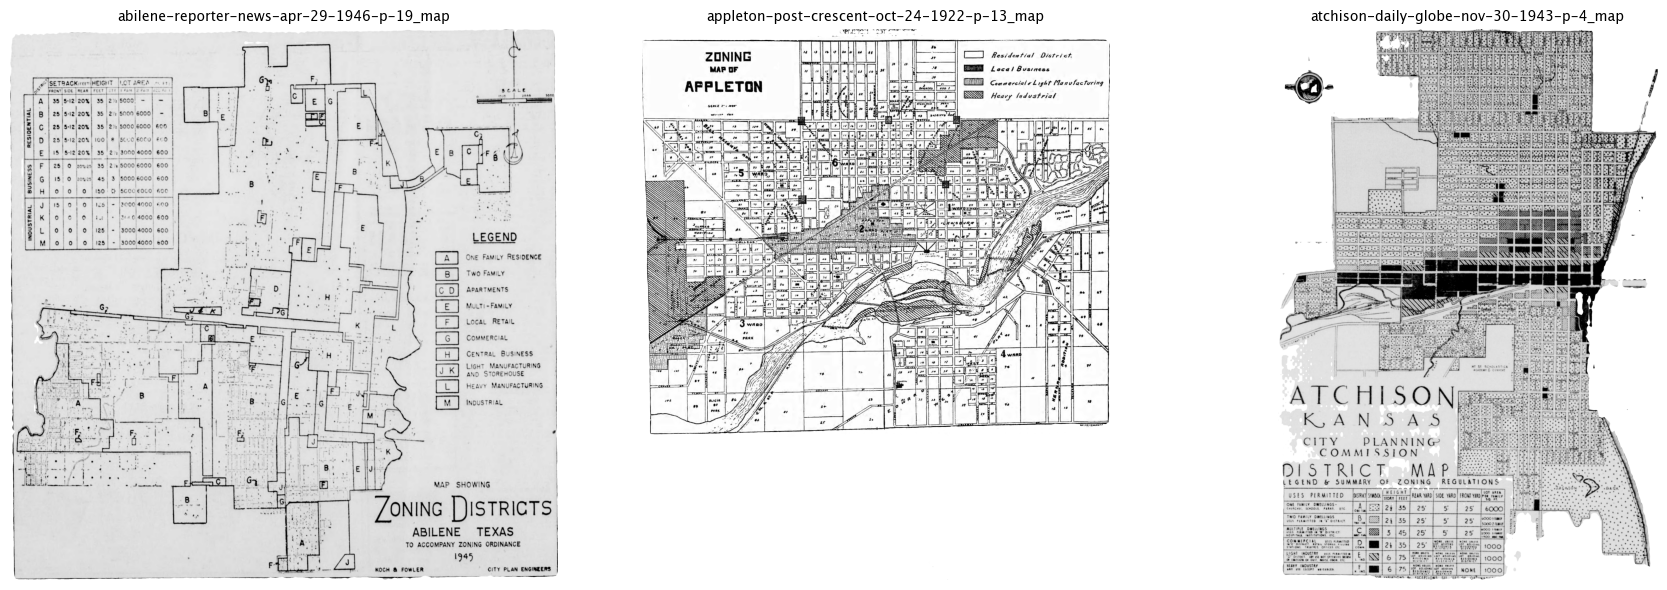

In [ ]:
# Find all cropped map images in the output directory
output_dir = Path("output")
map_files = sorted(output_dir.glob("*_map.png"))
input_dir = Path("input")

print(f"Found {len(map_files)} cropped map images:")
for f in map_files:
    print(f"  - {f.name}")

# Display the maps
fig, axes = plt.subplots(1, len(map_files), figsize=(6*len(map_files), 6))
if len(map_files) == 1:
    axes = [axes]

for ax, map_file in zip(axes, map_files):
    img = Image.open(map_file)
    ax.imshow(img)
    ax.set_title(map_file.stem, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Extract Legend from All Maps

In [8]:
# Extract legend and pattern information from each map
all_results = []

for map_file in map_files:
    print(f"Processing: {map_file.name}...")
    try:
        result = extract_legend_from_map(map_file, model)
        all_results.append(result)
        print(f"  ✓ Extracted successfully")
    except Exception as e:
        print(f"  ✗ Error: {e}")
        all_results.append({
            "source_file": map_file.name,
            "error": str(e)
        })

print(f"\nCompleted processing {len(all_results)} maps!")

Processing: abilene-reporter-news-apr-29-1946-p-19_map.png...
  ✓ Extracted successfully
Processing: appleton-post-crescent-oct-24-1922-p-13_map.png...
  ✓ Extracted successfully
Processing: atchison-daily-globe-nov-30-1943-p-4_map.png...
  ✓ Extracted successfully

Completed processing 3 maps!


## Display All Results

In [9]:
# Display formatted results for each map
for result in all_results:
    if "error" not in result:
        display_extraction_result(result)
    else:
        print(f"\n❌ Error processing {result['source_file']}: {result['error']}")


📄 Source: abilene-reporter-news-apr-29-1946-p-19_map.png

📍 Map Subject: Zoning districts of Abilene, Texas
📌 Map Title: MAP SHOWING ZONING DISTRICTS ABILENE TEXAS TO ACCOMPANY ZONING ORDINANCE 1945

🏷️ Has Legend: Yes
📍 Legend Location: bottom-right

📋 Legend Items (10):
----------------------------------------

  1. PATTERN
     Visual: Area filled with dense, fine black dots
     Meaning: One Family Residence
     Pattern: dots (dense density)
     Color: black

  2. SOLID_FILL
     Visual: Unfilled area (white background)
     Meaning: Two Family
     Pattern: none (none density)
     Color: white

  3. SOLID_FILL
     Visual: Unfilled area (white background)
     Meaning: Apartments
     Pattern: none (none density)
     Color: white

  4. SOLID_FILL
     Visual: Unfilled area (white background)
     Meaning: Multi-Family
     Pattern: none (none density)
     Color: white

  5. SOLID_FILL
     Visual: Unfilled area (white background)
     Meaning: Local Retail
     Pattern: none

## Summary Table

In [10]:
# Create a summary table of all extractions
print("\n" + "="*80)
print("📊 EXTRACTION SUMMARY")
print("="*80)

summary_data = []
for result in all_results:
    if "error" not in result:
        summary_data.append({
            "File": result.get("source_file", "Unknown"),
            "Has Legend": "✓" if result.get("has_legend") else "✗",
            "Legend Items": len(result.get("legend_items", [])),
            "Patterns Found": len(result.get("patterns_on_map", [])),
            "Subject": result.get("map_subject", "Unknown")[:40] + "..." if len(result.get("map_subject", "")) > 40 else result.get("map_subject", "Unknown")
        })
    else:
        summary_data.append({
            "File": result.get("source_file", "Unknown"),
            "Has Legend": "ERROR",
            "Legend Items": "-",
            "Patterns Found": "-",
            "Subject": result.get("error", "Unknown error")[:40]
        })

# Print as table
if summary_data:
    # Header
    print(f"\n{'File':<50} {'Legend':<8} {'Items':<7} {'Patterns':<10} {'Subject':<40}")
    print("-" * 115)
    
    for row in summary_data:
        print(f"{row['File']:<50} {row['Has Legend']:<8} {str(row['Legend Items']):<7} {str(row['Patterns Found']):<10} {row['Subject']:<40}")

print("\n" + "="*80)


📊 EXTRACTION SUMMARY

File                                               Legend   Items   Patterns   Subject                                 
-------------------------------------------------------------------------------------------------------------------
abilene-reporter-news-apr-29-1946-p-19_map.png     ✓        10      2          Zoning districts of Abilene, Texas      
appleton-post-crescent-oct-24-1922-p-13_map.png    ✓        4       6          Zoning districts of Appleton            
atchison-daily-globe-nov-30-1943-p-4_map.png       ✓        6       9          Zoning regulations and land use district...



## Save Results to JSON

In [11]:
# Save all extraction results to a JSON file for later use
output_json_path = output_dir / "legend_extractions.json"

with open(output_json_path, "w") as f:
    json.dump(all_results, f, indent=2)

print(f"✅ Results saved to: {output_json_path}")

✅ Results saved to: output/legend_extractions.json


## Raw JSON Output

In [12]:
# Display raw JSON for inspection
print(json.dumps(all_results, indent=2))

[
  {
    "has_legend": true,
    "legend_items": [
      {
        "symbol_type": "pattern",
        "visual_description": "Area filled with dense, fine black dots",
        "meaning": "One Family Residence",
        "pattern_details": {
          "pattern_type": "dots",
          "color": "black",
          "density": "dense"
        }
      },
      {
        "symbol_type": "solid_fill",
        "visual_description": "Unfilled area (white background)",
        "meaning": "Two Family",
        "pattern_details": {
          "pattern_type": "none",
          "color": "white",
          "density": "none"
        }
      },
      {
        "symbol_type": "solid_fill",
        "visual_description": "Unfilled area (white background)",
        "meaning": "Apartments",
        "pattern_details": {
          "pattern_type": "none",
          "color": "white",
          "density": "none"
        }
      },
      {
        "symbol_type": "solid_fill",
        "visual_description": "Unfilled ar

## Extract Legend Images

Crop the actual legend region from each map, then extract individual pattern swatches for zone matching.

In [13]:
# Additional imports for legend extraction
%pip install opencv-python numpy
import cv2
import numpy as np
import io
import base64

print("✅ Additional imports loaded")

Note: you may need to restart the kernel to use updated packages.
✅ Additional imports loaded


In [14]:
def extract_legend_bbox(image_path: Path, model) -> dict:
    """
    Use VLM to detect the bounding box of the legend in the map image.
    Returns pixel coordinates of the legend region.
    """
    img = Image.open(image_path)
    w, h = img.size
    
    prompt = f"""This is a historical zoning/planning map image. Size: {w}x{h} pixels.

Find the LEGEND or KEY - this is typically a box or section that shows:
- Pattern samples (rectangles with different fills/hatching)
- Labels explaining what each pattern means (zone types)
- Usually located in a corner or along an edge of the map

The legend might be titled "LEGEND", "KEY", "ZONE KEY", or similar.

Return ONLY a JSON object with the legend's bounding box in PIXEL coordinates:
{{"x1": left_edge, "y1": top_edge, "x2": right_edge, "y2": bottom_edge, "found": true}}

IMPORTANT:
- Be GENEROUS with the bounding box - include the entire legend area with some padding
- Include both the pattern samples AND their labels
- If there are multiple legend sections, include them all in one bounding box

If absolutely no legend is visible, return: {{"found": false, "reason": "explanation"}}"""

    # Convert to PNG bytes
    buffer = io.BytesIO()
    img.save(buffer, format='PNG')
    png_bytes = base64.b64encode(buffer.getvalue()).decode('utf-8')
    image_part = {"inline_data": {"mime_type": "image/png", "data": png_bytes}}
    
    response = model.generate_content([prompt, image_part])
    text = response.text
    
    # Parse JSON
    import re
    text = re.sub(r'```json\s*', '', text)
    text = re.sub(r'```\s*', '', text)
    start = text.find('{')
    end = text.rfind('}') + 1
    if start != -1 and end > 0:
        json_str = text[start:end]
        # Fix trailing commas (invalid JSON but common LLM output)
        json_str = re.sub(r',\s*]', ']', json_str)
        json_str = re.sub(r',\s*}', '}', json_str)
        result = json.loads(json_str)
        result['image_size'] = (w, h)
        return result
    return {"found": False}


def crop_legend(image_path: Path, bbox: dict, padding: int = 20) -> Image.Image:
    """Crop the legend region from the image with extra padding."""
    img = Image.open(image_path)
    x1 = max(0, bbox['x1'] - padding)
    y1 = max(0, bbox['y1'] - padding)
    x2 = min(img.width, bbox['x2'] + padding)
    y2 = min(img.height, bbox['y2'] + padding)
    return img.crop((x1, y1, x2, y2))


print("✅ Improved legend extraction functions defined")

✅ Improved legend extraction functions defined


In [15]:
# Process all maps and extract legend regions
import time

legend_crops = {}

for map_file in map_files:
    print(f"\n{'='*60}")
    print(f"Processing: {map_file.name}")
    
    # Detect legend bbox
    bbox = extract_legend_bbox(map_file, model)
    print(f"  Legend detection: {bbox}")
    
    if bbox.get('found', False):
        # Crop the legend
        legend_img = crop_legend(map_file, bbox)
        
        # Save it
        legend_path = output_dir / f"{map_file.stem}_legend.png"
        legend_img.save(legend_path)
        print(f"  ✅ Saved legend: {legend_path} ({legend_img.size})")
        
        legend_crops[map_file.stem] = {
            'bbox': bbox,
            'legend_path': legend_path,
            'legend_image': legend_img
        }
    else:
        print(f"  ❌ No legend found")
    
    # Rate limit
    time.sleep(1)

print(f"\n{'='*60}")
print(f"Extracted legends for {len(legend_crops)}/{len(map_files)} maps")


Processing: abilene-reporter-news-apr-29-1946-p-19_map.png
  Legend detection: {'x1': 2020, 'y1': 330, 'x2': 2750, 'y2': 950, 'found': True, 'image_size': (3599, 3621)}
  ✅ Saved legend: output/abilene-reporter-news-apr-29-1946-p-19_map_legend.png ((770, 660))

Processing: appleton-post-crescent-oct-24-1922-p-13_map.png
  Legend detection: {'x1': 2080, 'y1': 70, 'x2': 3300, 'y2': 250, 'found': True, 'image_size': (3594, 4233)}
  ✅ Saved legend: output/appleton-post-crescent-oct-24-1922-p-13_map_legend.png ((1260, 220))

Processing: atchison-daily-globe-nov-30-1943-p-4_map.png
  Legend detection: {'x1': 100, 'y1': 3400, 'x2': 1750, 'y2': 4070, 'found': True, 'image_size': (2870, 4168)}
  ✅ Saved legend: output/atchison-daily-globe-nov-30-1943-p-4_map_legend.png ((1690, 710))

Extracted legends for 3/3 maps


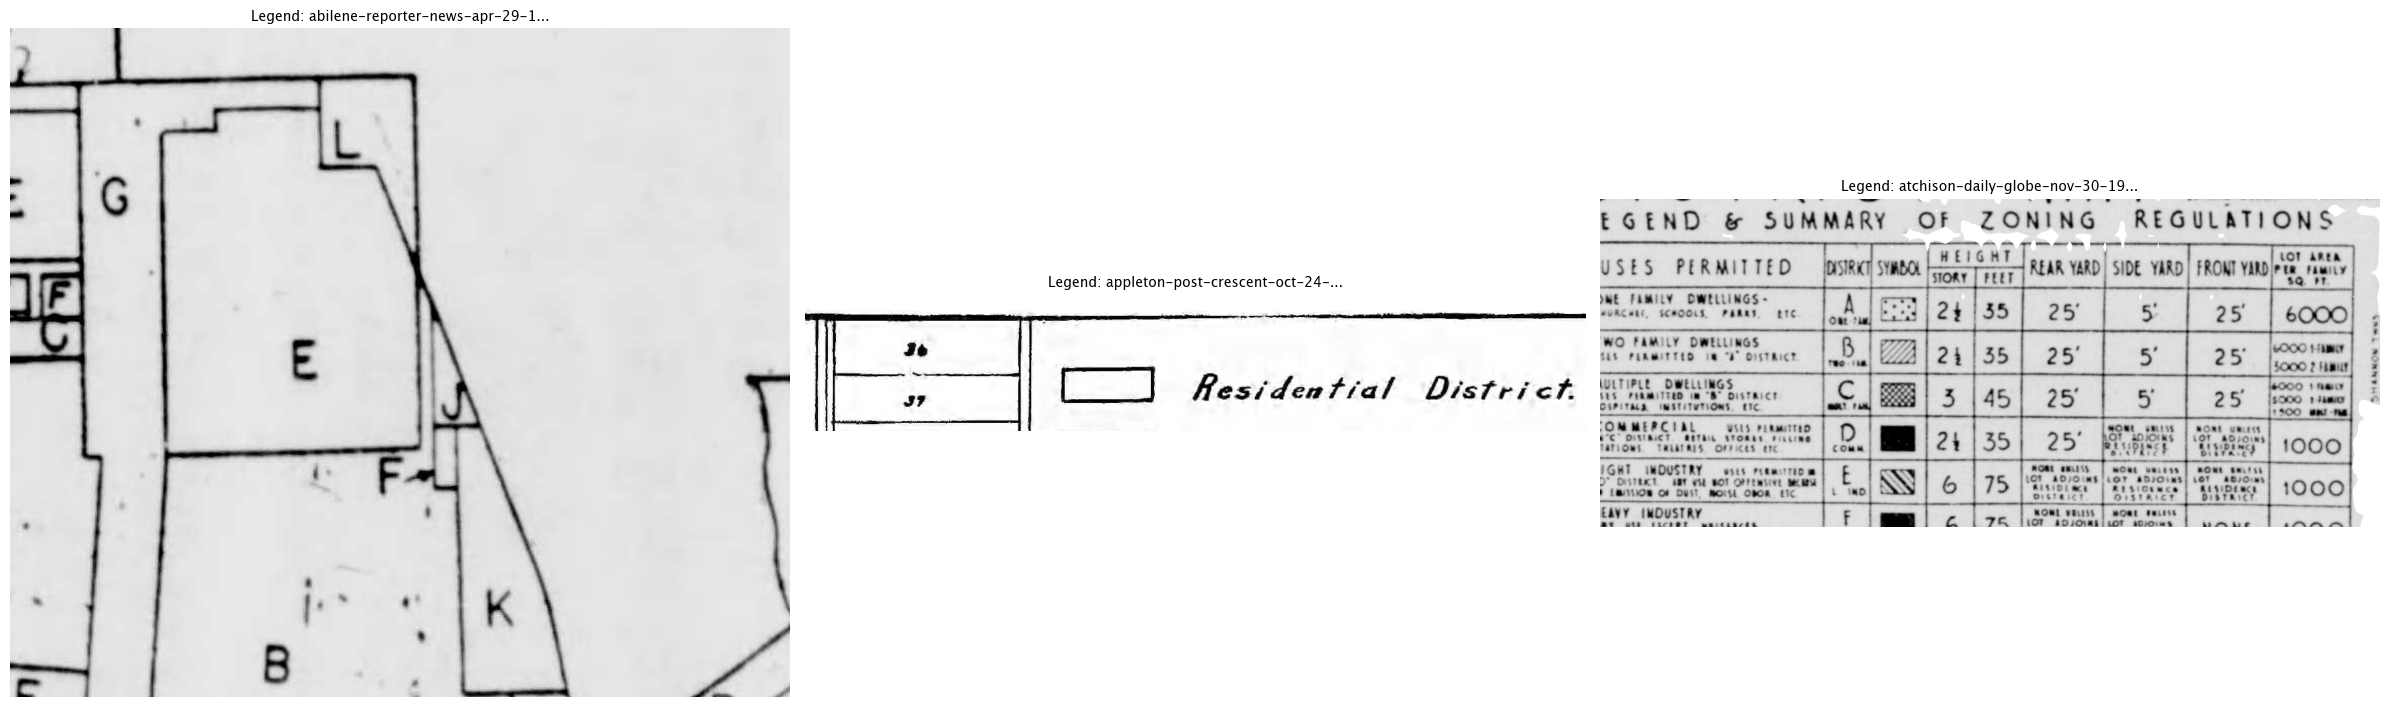

In [16]:
# Display the extracted legends
if legend_crops:
    n = len(legend_crops)
    fig, axes = plt.subplots(1, n, figsize=(8*n, 8))
    if n == 1:
        axes = [axes]

    for ax, (name, data) in zip(axes, legend_crops.items()):
        ax.imshow(data['legend_image'])
        ax.set_title(f"Legend: {name[:30]}...", fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No legends extracted yet")

## Extract Individual Legend Swatches

Now extract individual pattern swatches from each legend for zone matching.

In [17]:
def extract_legend_swatches(legend_image: Image.Image, model) -> list:
    """
    Extract individual pattern swatches from a legend image.
    Returns list of {x1, y1, x2, y2, meaning}
    """
    w, h = legend_image.size
    
    prompt = f"""This is a cropped LEGEND from a historical zoning/planning map. Image size: {w}x{h} pixels.

The legend shows different ZONE TYPES with pattern samples (rectangles/squares showing patterns like hatching, dots, solid fills, crosshatch, etc.) next to their labels.

For EACH legend entry, identify:
1. The PATTERN SWATCH - the rectangular area showing the visual pattern (NOT the text label)
2. The ZONE TYPE NAME from the text label next to it

IMPORTANT:
- Make the bounding boxes GENEROUS - include the full pattern sample with some margin
- Minimum swatch size should be at least 30x30 pixels
- Look for patterns like: solid fill, diagonal lines, horizontal lines, vertical lines, crosshatch, dots, stippling
- Zone types might include: Residential, Commercial, Industrial, Business, Single Family, Multi-Family, Agricultural, etc.
- Some legends use letters (A, B, C, R-1, C-2) or numbers - include those in the meaning

Return a JSON array with ALL legend entries found:
[
  {{"x1": left, "y1": top, "x2": right, "y2": bottom, "meaning": "Full zone type name", "pattern_type": "description of pattern"}},
  ...
]

If the image is low quality or you can't identify entries clearly, still try your best to extract what's visible."""

    buffer = io.BytesIO()
    legend_image.save(buffer, format='PNG')
    png_bytes = base64.b64encode(buffer.getvalue()).decode('utf-8')
    image_part = {"inline_data": {"mime_type": "image/png", "data": png_bytes}}
    
    response = model.generate_content([prompt, image_part])
    text = response.text
    
    # Parse JSON array
    import re
    text = re.sub(r'```json\s*', '', text)
    text = re.sub(r'```\s*', '', text)
    start = text.find('[')
    end = text.rfind(']') + 1
    if start != -1 and end > 0:
        json_str = text[start:end]
        # Fix trailing commas (invalid JSON but common LLM output)
        json_str = re.sub(r',\s*]', ']', json_str)
        json_str = re.sub(r',\s*}', '}', json_str)
        swatches = json.loads(json_str)
        
        # Post-process: ensure minimum swatch size
        processed = []
        for s in swatches:
            x1, y1, x2, y2 = int(s['x1']), int(s['y1']), int(s['x2']), int(s['y2'])
            
            # Ensure minimum size of 30x30
            if x2 - x1 < 30:
                center_x = (x1 + x2) // 2
                x1 = max(0, center_x - 20)
                x2 = min(w, center_x + 20)
            if y2 - y1 < 30:
                center_y = (y1 + y2) // 2
                y1 = max(0, center_y - 20)
                y2 = min(h, center_y + 20)
            
            s['x1'], s['y1'], s['x2'], s['y2'] = x1, y1, x2, y2
            processed.append(s)
        
        return processed
    return []


print("✅ Improved swatch extraction function defined")

✅ Improved swatch extraction function defined


In [18]:
# Extract swatches from each legend
import time

all_swatches = {}

for name, data in legend_crops.items():
    print(f"\n{'='*60}")
    print(f"Extracting swatches from: {name}")
    print(f"Legend size: {data['legend_image'].size}")
    
    swatches = extract_legend_swatches(data['legend_image'], model)
    print(f"  Found {len(swatches)} swatches")
    
    swatch_images = []
    for i, s in enumerate(swatches):
        try:
            # Crop the swatch
            x1, y1, x2, y2 = int(s['x1']), int(s['y1']), int(s['x2']), int(s['y2'])
            swatch_img = data['legend_image'].crop((x1, y1, x2, y2))
            
            # Clean filename - handle special characters
            meaning = s.get('meaning', f'unknown_{i}')
            clean_meaning = "".join(c if c.isalnum() or c in '_-' else '_' for c in meaning[:30])
            swatch_path = output_dir / f"{name}_swatch_{i}_{clean_meaning}.png"
            swatch_img.save(swatch_path)
            
            pattern_type = s.get('pattern_type', 'unknown')
            swatch_images.append({
                'image': swatch_img,
                'path': swatch_path,
                'meaning': meaning,
                'pattern_type': pattern_type,
                'bbox': (x1, y1, x2, y2)
            })
            print(f"    [{i}] {meaning}: {swatch_img.size} - {pattern_type}")
        except Exception as e:
            print(f"    [{i}] Error: {e}")
    
    all_swatches[name] = swatch_images
    time.sleep(1)  # Rate limit

print(f"\n{'='*60}")
print(f"✅ Extracted swatches for {len(all_swatches)} maps")
for name, swatches in all_swatches.items():
    print(f"  {name}: {len(swatches)} swatches")


Extracting swatches from: abilene-reporter-news-apr-29-1946-p-19_map
Legend size: (770, 660)
  Found 6 swatches
    [0] C: (35, 35) - Solid white
    [1] G: (80, 102) - Solid white
    [2] E: (228, 291) - Solid white
    [3] L: (47, 75) - Solid white
    [4] K: (74, 117) - Solid white
    [5] B: (496, 146) - Stippling

Extracting swatches from: appleton-post-crescent-oct-24-1922-p-13_map
Legend size: (1260, 220)
  Found 1 swatches
    [0] Residential District.: (145, 57) - Empty rectangle (no fill)

Extracting swatches from: atchison-daily-globe-nov-30-1943-p-4_map
Legend size: (1690, 710)
  Found 6 swatches
    [0] ONE FAMILY DWELLINGS - CHURCHES, SCHOOLS, PARKS, ETC.: (100, 60) - Scattered dots
    [1] TWO FAMILY DWELLINGS - USES PERMITTED IN "A" DISTRICT.: (100, 60) - Diagonal lines (top-left to bottom-right)
    [2] MULTIPLE DWELLINGS - USES PERMITTED IN "B" DISTRICT - HOSPITALS, INSTITUTIONS, ETC.: (100, 60) - Crosshatch (diagonal lines in both directions)
    [3] COMMERCIAL - US


Swatches for: abilene-reporter-news-apr-29-1946-p-19_map


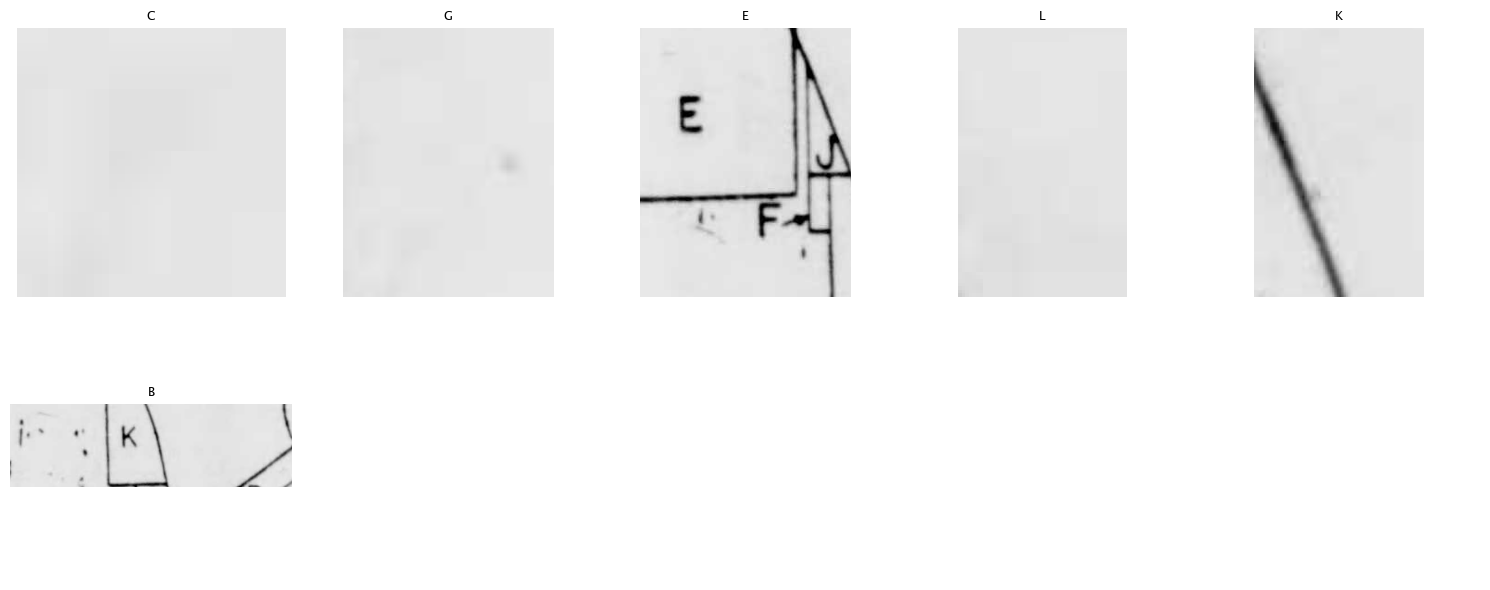


Swatches for: appleton-post-crescent-oct-24-1922-p-13_map


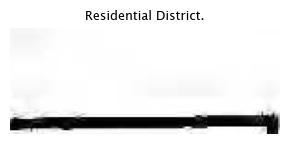


Swatches for: atchison-daily-globe-nov-30-1943-p-4_map


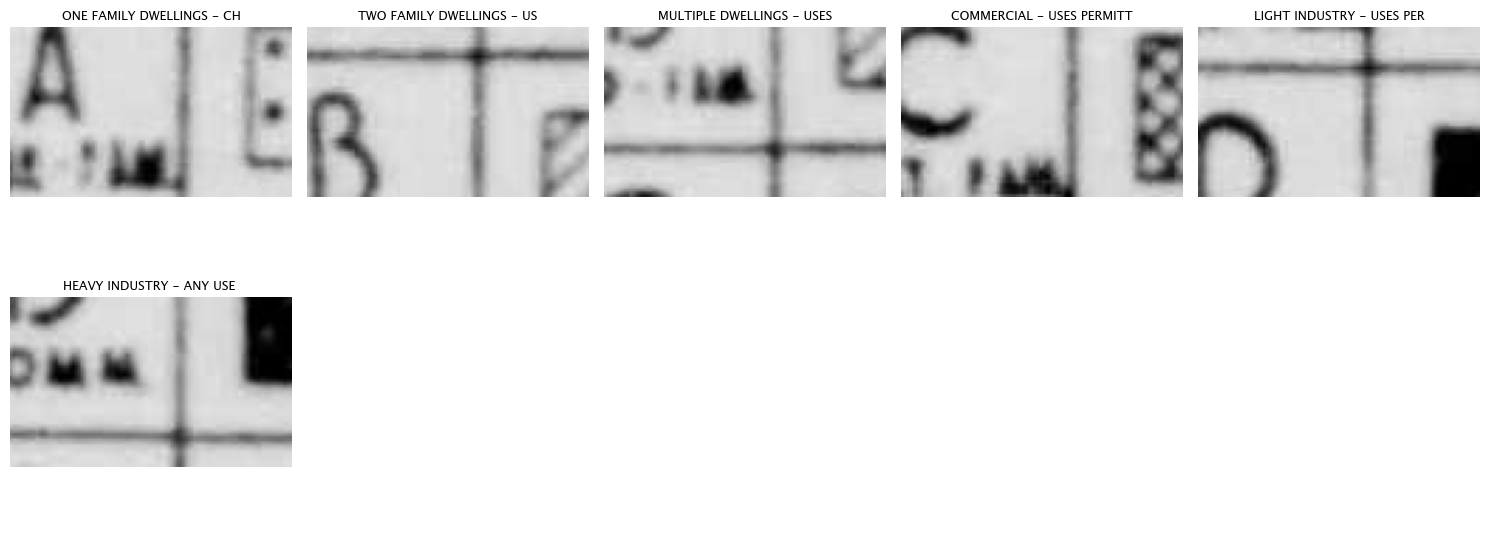

In [19]:
# Display all swatches for each map
for name, swatches in all_swatches.items():
    if not swatches:
        continue
    
    print(f"\n{'='*60}")
    print(f"Swatches for: {name}")
    
    n = len(swatches)
    cols = min(n, 5)
    rows = (n + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    axes = np.array(axes).flatten() if n > 1 else [axes]
    
    for ax, swatch in zip(axes, swatches):
        ax.imshow(swatch['image'])
        ax.set_title(swatch['meaning'][:25], fontsize=9)
        ax.axis('off')
    
    # Hide unused axes
    for ax in axes[n:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [20]:
# Save the swatch metadata for zone matching
swatch_metadata = {}

for name, swatches in all_swatches.items():
    swatch_metadata[name] = [
        {
            'meaning': s['meaning'],
            'swatch_path': str(s['path']),
            'bbox': s['bbox']
        }
        for s in swatches
    ]

# Save to JSON
with open(output_dir / "legend_swatches.json", "w") as f:
    json.dump(swatch_metadata, f, indent=2)

print(f"✅ Saved swatch metadata to: {output_dir / 'legend_swatches.json'}")
print(json.dumps(swatch_metadata, indent=2))

✅ Saved swatch metadata to: output/legend_swatches.json
{
  "abilene-reporter-news-apr-29-1946-p-19_map": [
    {
      "meaning": "C",
      "swatch_path": "output/abilene-reporter-news-apr-29-1946-p-19_map_swatch_0_C.png",
      "bbox": [
        170,
        293,
        205,
        328
      ]
    },
    {
      "meaning": "G",
      "swatch_path": "output/abilene-reporter-news-apr-29-1946-p-19_map_swatch_1_G.png",
      "bbox": [
        160,
        225,
        240,
        327
      ]
    },
    {
      "meaning": "E",
      "swatch_path": "output/abilene-reporter-news-apr-29-1946-p-19_map_swatch_2_E.png",
      "bbox": [
        236,
        234,
        464,
        525
      ]
    },
    {
      "meaning": "L",
      "swatch_path": "output/abilene-reporter-news-apr-29-1946-p-19_map_swatch_3_L.png",
      "bbox": [
        439,
        241,
        486,
        316
      ]
    },
    {
      "meaning": "K",
      "swatch_path": "output/abilene-reporter-news-apr-29-1946-p-19_